In [1]:
import os
import pandas as pd 
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns
import itertools as it

os.chdir('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')
outdir = 'results/specimen_focused/rf_model/'

# set the random_state
random_state = 17

/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t")
protein_data = protein_data.T

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

In [3]:
protein_data.iloc[0:10]

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,0.000000,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,5.131593,11.29977,0.000000,18.23974,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,7.467110,11.17309,0.000000,18.78044,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662
TRP-42320,9.864851,12.077377,19.51503,15.249573,20.31637,16.43280,0.000000,11.175637,14.609944,11.623066,...,10.408501,12.05820,9.052232,19.54567,19.29934,12.597745,21.60748,21.39231,8.251945,8.295446
TRP-42344-2,6.511555,8.951251,15.81600,12.221067,19.18105,13.02495,0.000000,7.898414,10.936967,6.131300,...,4.296957,11.62870,7.202654,17.76965,17.58848,8.301189,20.18219,13.90253,5.003258,9.233825
TRP-42346,0.000000,9.064309,17.26677,12.228901,18.57382,15.59197,0.000000,8.050459,11.767221,8.412514,...,0.000000,11.68513,7.591140,19.91279,18.24508,9.179296,22.22960,16.14269,7.264674,7.225288
TRP-42368-1,6.062641,8.911608,17.52905,12.165053,15.78867,13.84802,0.000000,9.773661,10.866252,8.659381,...,5.221111,11.64325,5.598232,17.89600,18.43819,8.043051,18.99646,16.91153,7.098327,5.271134
TRP-42362-1,0.000000,10.999193,18.84235,12.599216,19.72633,17.22058,10.870631,10.169550,12.262359,11.872985,...,7.911661,11.78348,9.583279,20.33967,19.33894,11.446674,21.16150,20.66594,7.648793,8.838626


## Predicting IBD Diagnosis

In [4]:
# Extract the diagnosis column
task_data = clinical_data['ibd_diagnosis']

In [21]:
task_data

0          CD
1          CD
2          CD
3          UC
4          CD
       ...   
81    Control
82         UC
83         UC
84    Control
85    Control
Name: ibd_diagnosis, Length: 86, dtype: object

In [5]:
# X_train, y_train = protein_data, diagnosis
#X_train, X_test, y_train, y_test = train_test_split(protein_data, task_data, test_size=0.2, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(protein_data, task_data, test_size=0.2, random_state=random_state)

In [6]:
# resample to balance classes
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)

In [7]:
# Fit the model on the training data
model = RandomForestClassifier(random_state=0)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=0)

In [8]:
# Check the accuracy on the training data
train_accuracy = model.score(X_train_resampled, y_train_resampled)
print(f"Training Accuracy: {train_accuracy:.2f}")

Training Accuracy: 1.00


In [9]:
# Check the accuracy on the test data
test_accuracy = model.score(X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Testing Accuracy: 0.83


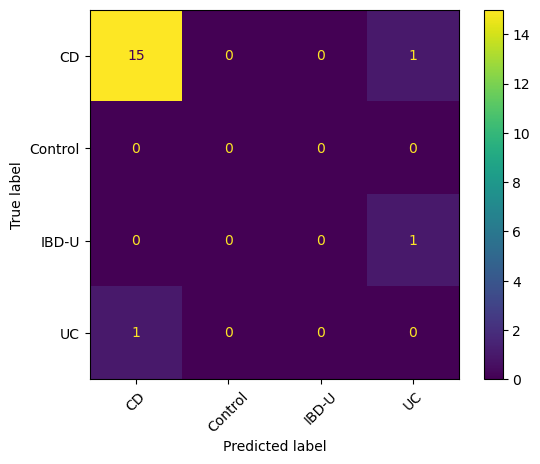

In [10]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Rotate x-tick labels
plt.xticks(rotation=45)  # Change the angle as needed (e.g., 90 for vertical)
plt.show()

fn = os.path.join(outdir, 'rf_model.ibd_diagnosis.confusion_matrix.png')
disp.figure_.savefig(fn, dpi=600)

In [11]:
# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          CD       0.94      0.94      0.94        16
       IBD-U       0.00      0.00      0.00         1
          UC       0.00      0.00      0.00         1

    accuracy                           0.83        18
   macro avg       0.31      0.31      0.31        18
weighted avg       0.83      0.83      0.83        18



/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

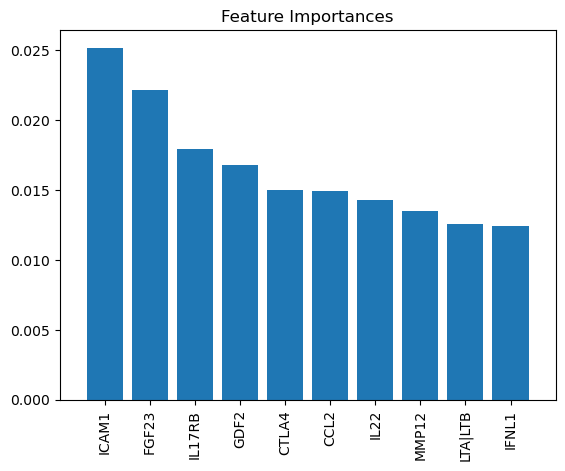

In [12]:
# get importance scores
importances = model.feature_importances_

# get data
topn = 10
indices = np.argsort(importances)[::-1][0:topn]
feature_names = protein_data.columns

# plot
fig, ax = plt.subplots()
ax.set_title("Feature Importances")
ax.bar(range(topn), importances[indices], align="center")
ax.set_xticks(range(topn), np.array(feature_names)[indices], rotation=90)
ax.set_xlim([-1, topn])

fn = os.path.join(outdir, 'rf_model.ibd_diagnosis.feature_importance.png')
fig.savefig(fn, dpi=600)

In [13]:
importances_df = pd.DataFrame([importances, feature_names]).T
importances_df.columns = ['score', 'protein']
importances_df = importances_df[['protein', 'score']]

In [14]:
outfn = os.path.join(outdir, 'rf_model.disease_activity.scores.tsv')
importances_df.to_csv(outfn, index=None, sep="\t")

In [15]:
importances_df.head()

,protein,score
0,AGER,0.00239
1,AGRP,0.002476
2,ANGPT1,0.000296
3,ANGPT2,0.002709
4,ANXA1,0.001464


### Bootstrap Analysis

In [16]:
bs_data = []
num_seeds = 100

for seed in range(num_seeds):

    model = RandomForestClassifier(random_state=seed)

    # Fit the model on the training data
    model.fit(X_train_resampled, y_train_resampled)

    # Check the accuracy on the training data
    train_accuracy = model.score(X_train_resampled, y_train_resampled)

    # Check the accuracy on the test data
    test_accuracy = model.score(X_test, y_test)

    # get importance scores
    importances = model.feature_importances_

    # get data
    topn = 10
    indices = np.argsort(importances)[::-1][0:topn]
    topn_feature_names = np.array(protein_data.columns)[indices]

    cdata = [seed, train_accuracy, test_accuracy, topn_feature_names]
    bs_data.append(cdata)

In [17]:
# load data into df
bs_df = pd.DataFrame(bs_data)
bs_df.columns = ['seed', 'train_acc', 'test_acc', 'top_genes']

# value counts for the top genes
dist_data = list(it.chain(*bs_df.top_genes.tolist()))
dist_df = pd.Series(dist_data).value_counts().to_frame().reset_index()
dist_df.rename(columns={'index': 'top_gene'}, inplace=True)
dist_df.loc[:, 'pct'] = dist_df.loc[:, 'count'] / num_seeds * 100

In [18]:
dist_df

,top_gene,count,pct
0,FGF23,95,95.0
1,MMP12,88,88.0
2,CCL2,62,62.0
3,EGF,59,59.0
4,IFNB1,54,54.0
5,CD276,50,50.0
6,IL17RB,49,49.0
7,IL6ST,49,49.0
8,IFNL1,47,47.0
9,GDF2,47,47.0


Text(0.5, 0, 'Percent')

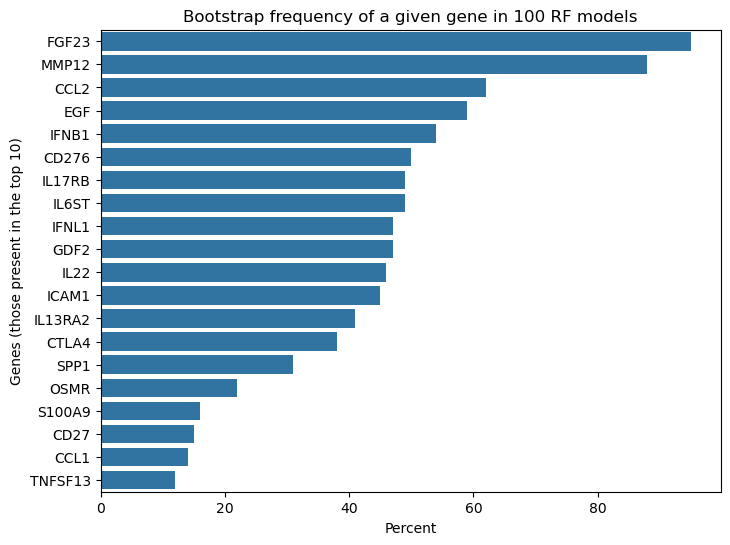

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(dist_df.iloc[0:20], y='top_gene', x='pct')

ax.set_title(f'Bootstrap frequency of a given gene in {num_seeds} RF models')
ax.set_ylabel(f'Genes (those present in the top {topn})')
ax.set_xlabel('Percent')

In [20]:
outfn = os.path.join(outdir, 'bootstrap_results.ibd_subtypes.tsv')
dist_df.to_csv(outfn, sep='\t', index=False, header=True)

## Predicting Disease Activity

In [21]:
# Extract the diagnosis column
task_data = clinical_data['disease_activity']

In [22]:
# resample to balance classes
X_resampled, task_resampled = RandomOverSampler(random_state=random_state).fit_resample(protein_data, task_data)

In [23]:
task_resampled.value_counts()

disease_activity
Quiescent                62
Moderate                 62
Mild                     62
N/A (Non-IBD Control)    62
Name: count, dtype: int64

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(protein_data, task_data, test_size=0.2, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, task_resampled, test_size=0.2, random_state=random_state)
model = RandomForestClassifier(random_state=0)

In [25]:
# Fit the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [26]:
# Check the accuracy on the training data
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

Training Accuracy: 1.00


In [27]:
# Check the accuracy on the test data
test_accuracy = model.score(X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Testing Accuracy: 1.00


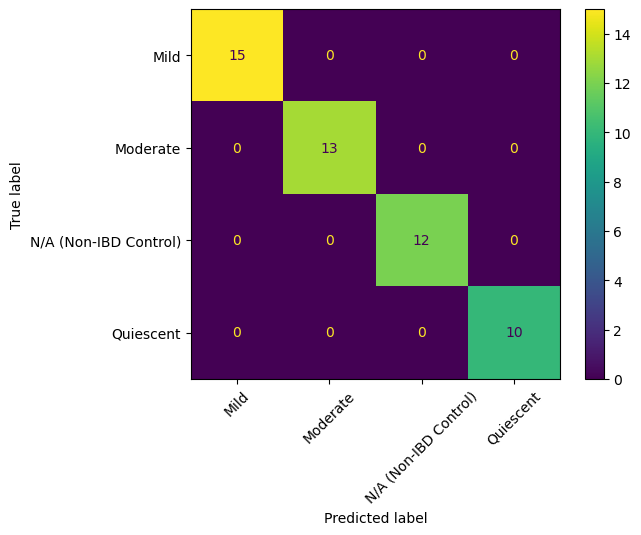

In [28]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Rotate x-tick labels
plt.xticks(rotation=45)  # Change the angle as needed (e.g., 90 for vertical)
plt.show()

fn = os.path.join(outdir, 'rf_model.disease_activity.confusion_matrix.png')
disp.figure_.savefig(fn, dpi=600)

In [29]:
# Print the classification report
print(classification_report(y_test, predictions))

                       precision    recall  f1-score   support

                 Mild       1.00      1.00      1.00        15
             Moderate       1.00      1.00      1.00        13
N/A (Non-IBD Control)       1.00      1.00      1.00        12
            Quiescent       1.00      1.00      1.00        10

             accuracy                           1.00        50
            macro avg       1.00      1.00      1.00        50
         weighted avg       1.00      1.00      1.00        50



In [30]:
# get importance scores
importances = model.feature_importances_
feature_names = model.feature_names_in_

# get data
topn = 10
indices = np.argsort(importances)[::-1][0:topn]
feature_names = protein_data.columns

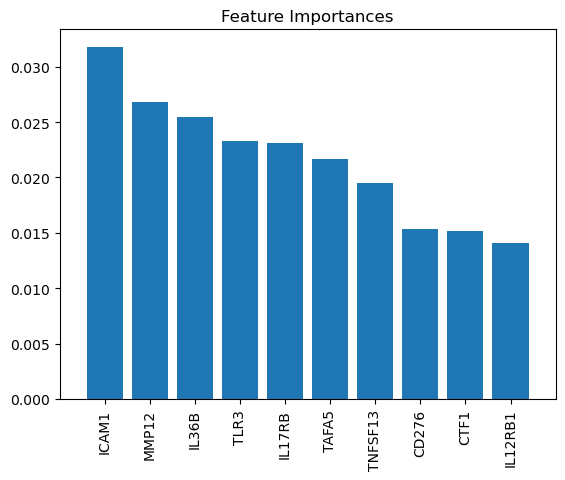

In [31]:
# plot
fig, ax = plt.subplots()
ax.set_title("Feature Importances")
ax.bar(range(topn), importances[indices], align="center")
ax.set_xticks(range(topn), np.array(feature_names)[indices], rotation=90)
ax.set_xlim([-1, topn])

fn = os.path.join(outdir, 'rf_model.disease_activity.feature_importance.png')
fig.savefig(fn, dpi=600)

In [32]:
importances_df = pd.DataFrame([importances, feature_names]).T
importances_df.columns = ['score', 'protein']
importances_df = importances_df[['protein', 'score']]

In [33]:
outfn = os.path.join(outdir, 'rf_model.disease_activity.scores.tsv')
importances_df.to_csv(outfn, index=None, sep="\t")

In [34]:
importances_df.head(20)

,protein,score
0,AGER,0.009232
1,AGRP,0.003677
2,ANGPT1,0.001271
3,ANGPT2,0.001523
4,ANXA1,0.001788
5,AREG,0.003832
6,BDNF,0.0
7,BMP7,0.000692
8,BST2,0.005298
9,C1QA,0.001817


### Bootstrap Analysis

In [35]:
bs_data = []
num_seeds = 100

for seed in range(num_seeds):

    model = RandomForestClassifier(random_state=seed)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Check the accuracy on the training data
    train_accuracy = model.score(X_train, y_train)

    # Check the accuracy on the test data
    test_accuracy = model.score(X_test, y_test)

    # get importance scores
    importances = model.feature_importances_

    # get data
    topn = 10
    indices = np.argsort(importances)[::-1][0:topn]
    topn_feature_names = np.array(protein_data.columns)[indices]

    cdata = [seed, train_accuracy, test_accuracy, topn_feature_names]
    bs_data.append(cdata)

In [36]:
# load data into df
bs_df = pd.DataFrame(bs_data)
bs_df.columns = ['seed', 'train_acc', 'test_acc', 'top_genes']

# value counts for the top genes
dist_data = list(it.chain(*bs_df.top_genes.tolist()))
dist_df = pd.Series(dist_data).value_counts().to_frame().reset_index()
dist_df.rename(columns={'index': 'top_gene'}, inplace=True)
dist_df.loc[:, 'pct'] = dist_df.loc[:, 'count'] / num_seeds * 100

In [37]:
dist_df

,top_gene,count,pct
0,TLR3,99,99.0
1,MMP12,99,99.0
2,ICAM1,92,92.0
3,IL17RB,88,88.0
4,TAFA5,81,81.0
5,CD80,60,60.0
6,TNFSF13,50,50.0
7,IL12RB1,44,44.0
8,CXCL16,43,43.0
9,IL36B,42,42.0


Text(0.5, 0, 'Percent')

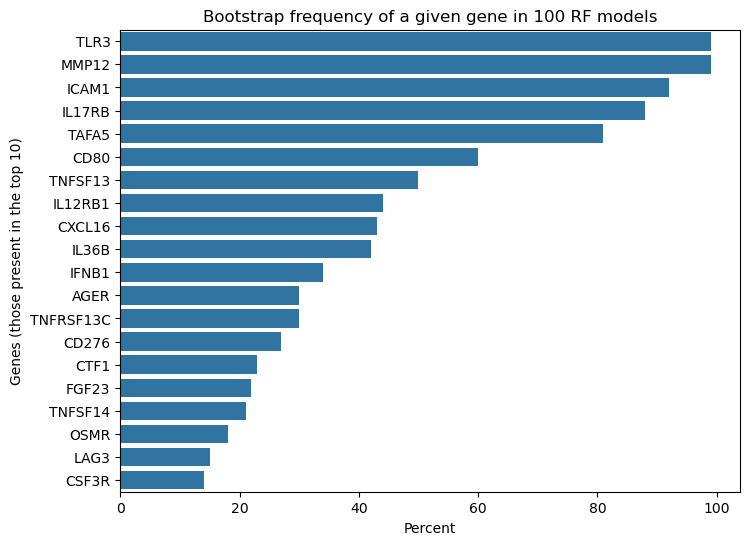

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(dist_df.iloc[0:20], y='top_gene', x='pct')

ax.set_title(f'Bootstrap frequency of a given gene in {num_seeds} RF models')
ax.set_ylabel(f'Genes (those present in the top {topn})')
ax.set_xlabel('Percent')

In [39]:
outfn = os.path.join(outdir, 'bootstrap_results.da.tsv')
dist_df.to_csv(outfn, sep='\t', index=False, header=True)